# Multiclass classification from CSV file
In this example we'll train a classifier to predict the process of events using the data from the [HiggsML Kaggle challenge](https://www.kaggle.com/c/higgs-boson) as a proxy to binary classification.
1. Data is imported from CSV format
1. Data is preprocessed
1. Initial feature selection is performed
1. An ensemble of SELU-based networks is trained with 1-cycle learning rate and beta-1 policy using a categorical entity embedding and train-time data augmentation
    - If the binary classification example is run first, then pretrained embedding weights are loaded and refined
1. The resulting ensemble is evaluated on validation data using test-time data augmentation
1. HEP-specific plotting and discriminant binning is presented
1. The model is interpreted via feature importance, embedding examination, and partial dependencies

We'll use the version of the data available from the [CERN OpenData portal](http://opendata.cern.ch/record/328?ln=en), however it is also available from [Kaggle](https://www.kaggle.com/c/higgs-boson). Alternatively, uncomment and run the cell below:

In [1]:
#!mkdir data
#!wget -O data/atlas-higgs-challenge-2014-v2.csv.gz http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
#!gunzip data/atlas-higgs-challenge-2014-v2.csv.gz

If running in Google Collab, uncomment and run the cell below to install LUMIN

In [2]:
# !pip install lumin
# !git clone https://github.com/SauceCat/PDPbox.git && cd PDPbox && pip install -e .

--> **RESTART INSTANCE TO ENSURE PDPBOX IS FOUND** <--

### Basic Modules

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from pathlib import Path
PATH = Path('./data')

## Data preparation

### Data import from CSV file 
Read file into a pandas dataframe.

In [5]:
data = pd.read_csv(PATH/'atlas-higgs-challenge-2014-v2.csv')

In [6]:
data.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


In [7]:
data.drop(columns=['Weight'], inplace=True)
data['Label'] = data['Label'].map({'s':1, 'b':0})
data.rename(index=str, columns={"KaggleWeight": "gen_weight", 'PRI_met': 'PRI_met_pt', 'Label':'gen_target'}, inplace=True)

df = pd.DataFrame(data.loc[data.KaggleSet == 't'])
df.drop(columns=['KaggleSet'], inplace=True)
    
test = pd.DataFrame(data.loc[(data.KaggleSet == 'b') | (data.KaggleSet == 'v')])
test['private'] = 0
test.loc[(data.KaggleSet == 'v'), 'private'] = 1
test.drop(columns=['KaggleSet'], inplace=True)

### Preprocessing
Having imported the data, we now need to further process it into form suitable for training the classifier.

We can start by moving a Cartesian coordinate system; the HEP standard of $p_T,\ \eta,\ \phi$ can be a bit tricky, since $\phi$ is cyclical in nature, and $\eta$ is highly non-linear. Additionally, since the class of each event is invariant under transformations of the absolute orientation of each event, we can remove several symetries in the data by rotating each event to have the same orientation. However, in this example we will leave will instead randomly rotate the event during training and testing (train-time/test-time data augmentation).

`proc_event` has options to set all events to have `ref_vec_0` at $\phi=0$ and be always in the positive $\eta$ region. The remaining symmetry of transverse reflection can be fixed by setting `ref_vec_1` to be in the positive $\phi$ region. The vectors can then transformed into Cartesian system via `use_cartesian` flag. The original vectors are automatically dropped, but can be kept if added to `keep_feat`. It can sometimes be useful to keep the absolute amount of $p_T^{\mathrm{miss}}$, since this is now non-linear combination of $p_x^{\mathrm{miss}}$ and $p_y^{\mathrm{miss}}$.

Additionally, we'll process the default values for missing jets (-999.0) to NaNs to avoid them biasing our preprocessing.

In [8]:
print([f for f in df.columns])

['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met_pt', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt', 'gen_target', 'gen_weight']


In [9]:
from lumin.data_processing.hep_proc import proc_event
proc_event(df, use_cartesian=True, default_vals=[-999.0], keep_feats=['PRI_met_pt'])
proc_event(test, use_cartesian=True, default_vals=[-999.0], keep_feats=['PRI_met_pt'])

Converting to use_cartesian coordinates
Converting to use_cartesian coordinates


For quick access, we'll define here all the sets of features we'll later want use.

In [10]:
gen_feats = [f for f in df.columns if 'gen_' in f]
misc_feats = ['EventId']
wgt_feat = 'gen_weight'
cat_feats = ['PRI_jet_num']
cont_feats = [f for f in df.columns if f not in gen_feats+cat_feats+misc_feats]
print(len(cat_feats), cat_feats)
print(len(cont_feats), cont_feats)
train_feats = cont_feats + cat_feats

1 ['PRI_jet_num']
30 ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_pt']


To create our validation set, we'll eventually pull out a random sample, however it can be useful to ensure as much similarity as possible by doing a stratified split using the categories and classes in the data. `ids2unique` maps each set of categories to a unique integer, allowing us to create a single set of values to use as the stratification key.

In [11]:
from lumin.utils.misc import ids2unique

df['gen_strat_key'] = ids2unique(df[['gen_target'] + cat_feats].values)

In [12]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [13]:
df.columns[df.isna().any()].tolist()

['DER_mass_MMC',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_subleading_px',
 'PRI_jet_subleading_py',
 'PRI_jet_subleading_pz',
 'PRI_jet_leading_px',
 'PRI_jet_leading_py',
 'PRI_jet_leading_pz']

In [14]:
test.columns[test.isna().any()].tolist()

['DER_mass_MMC',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_subleading_px',
 'PRI_jet_subleading_py',
 'PRI_jet_subleading_pz',
 'PRI_jet_leading_px',
 'PRI_jet_leading_py',
 'PRI_jet_leading_pz']

We've got some NaNs in the data, however this is due to non-existent jets, float precision, and algorithm non-convergence. `FoldYielder` automatically applied `np.nan_to_num` so no worries.

#### Train-validation split 

In [15]:
from sklearn.model_selection import train_test_split 

val_sz = 0.2
train_df, val_df = train_test_split(df, test_size=val_sz, stratify=df.gen_strat_key, random_state=1337)

Having pulled out a stratified random subsample, we can check whether it really is representative of the train data (and our test set if we had one) by seeing whether we can use the input features to identify which dataset each event belongs to. If there our some features which allow the sets to be identified, then we could remove them from the inputs to improve the generalisation of the model.

`check_val_set` runs some random forests to try and predict the originating datasets of the events, and then returns the area under the ROC curve for the classifiers. Ideally this should be 0.5, indicating it can only do as well as random guessing. Training and inference use weights to account for the fact that the datasets may have uneven populations.

In [16]:
from lumin.utils.data import check_val_set

check_val_set(train_df[train_feats], val_df[train_feats], test[train_feats])

/home/giles/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)



AUC for train-validation discrimination = 0.4988862600264656
Top 10 most important features are:
   index                      Feature  Importance
0      0       DER_lep_eta_centrality    0.002652
1      1                   PRI_met_px    0.001515
2      2                   PRI_met_py    0.001389
3      3                   DER_sum_pt    0.001263
4      4                   PRI_tau_px    0.001010
5      5       DER_met_phi_centrality    0.000758
6      6  DER_mass_transverse_met_lep    0.000631
7      7                  PRI_jet_num    0.000379
8      8        PRI_jet_subleading_pz    0.000126
9      9           DER_deltar_tau_lep   -0.000253

AUC for test-validation discrimination = 0.5000993875181111
Top 10 most important features are:
   index                      Feature  Importance
0      0                 DER_mass_MMC    0.002612
1      1           PRI_jet_leading_py    0.002067
2      2                PRI_met_sumet    0.001959
3      3        PRI_jet_subleading_py    0.001523
4    

#### Final preprocessing
The network weights will use initialisation schemes which expect the inputs to be unit Gaussian. We'll use sklearn pipelines to package transformations which alter the data to have mean zero and standard deviation one.

In [17]:
from lumin.data_processing.pre_proc import fit_input_pipe

input_pipe = fit_input_pipe(train_df, cont_feats, PATH/'input_pipe')

In [18]:
train_df[cont_feats] = input_pipe.transform(train_df[cont_feats])
val_df[cont_feats] = input_pipe.transform(val_df[cont_feats])
test[cont_feats] = input_pipe.transform(test[cont_feats])

Since we'll be using entity embeddings for the categorical features, we want to transform their codes to start from zero and increase incrementaly. We also need to make sure the validation (and test) sets receive the same transformaitions as the training set.

`proc_cats` does this and returns dictionaries of the both the mapping that was applied, and the cardinality of each feature.

In [19]:
from lumin.data_processing.pre_proc import proc_cats

cat_maps, cat_szs = proc_cats(train_df, cat_feats, val_df, test)
cat_maps, cat_szs

(OrderedDict([('PRI_jet_num', {0: 0, 1: 1, 2: 2, 3: 3})]),
 OrderedDict([('PRI_jet_num', 4)]))

### Sample splitting
We know that the signal data consists of a single sample ($h\rightarrow\tau\tau$) and that the background contains three different samples: $t\bar{t}$, $W$-boson, and $Z\rightarrow\tau\tau$. However we aren't explicitly told which sample each event belongs to. Nevertheless, we can cluster events using their weight:

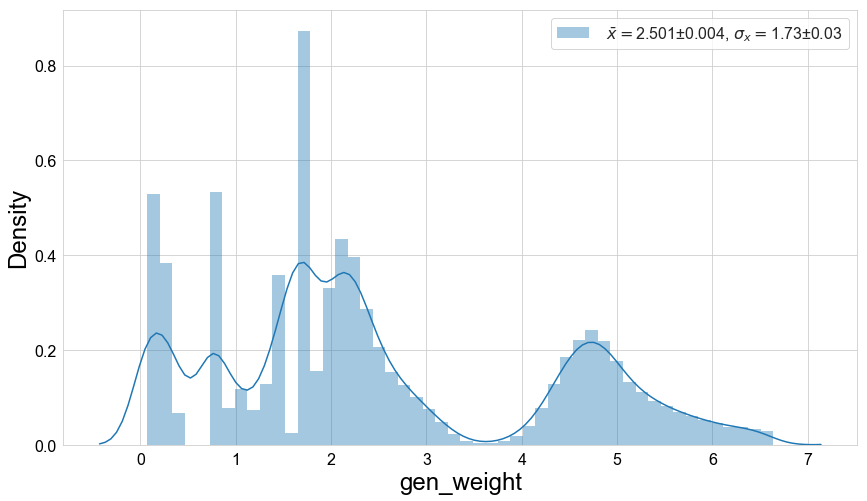

In [20]:
from lumin.plotting.data_viewing import plot_feat

plot_feat(df[df.gen_target==0], 'gen_weight')

Well, there are _basically_ three clusters there. Enough to work for this example, anyway. Lets cluster using _k_-means:

In [21]:
from sklearn.cluster import k_means

cluster = k_means(X=train_df.loc[train_df.gen_target == 0, 'gen_weight'].values[:,None], n_clusters=3)
train_df.loc[train_df.gen_target == 0, 'gen_sample'] = cluster[1]
train_df.loc[train_df.gen_target == 1, 'gen_sample'] = 3
val_df.loc[val_df.gen_target == 0, 'gen_sample'] = abs(val_df.loc[val_df.gen_target == 0, 'gen_weight'][None,:]-cluster[0][:,None]).argmin(axis=0)[0]
val_df.loc[val_df.gen_target == 1, 'gen_sample'] = 3

Lets check some of the features. `plot_feat` is a flexible function to provide indicative information about the 1D distribution of a feature. By default it will produce a weighted KDE+histogram for the [1,99] percentile of the data, as well as compute the mean and standard deviation of the data in this region. By passing a list of cuts and labels, it will plot multiple distributions of the same feature for different cuts. Since it is designed to provide quick, indicative information, more specific functions (such as `plot_kdes_from_bs`) should be used to provide final results.

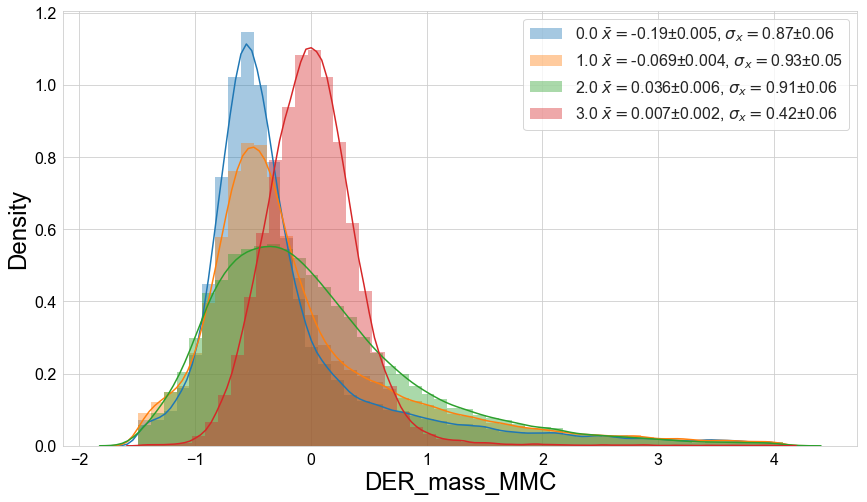

In [22]:
from lumin.plotting.data_viewing import plot_feat
plot_feat(train_df, 'DER_mass_MMC', cuts=[(train_df.gen_sample==s) for s in sorted(set(train_df.gen_sample))],
          labels=[str(s) for s in sorted(set(train_df.gen_sample))], show_moments=True)


We can also view this feature as a stacked histogram, with background (samples 0,1,2 stacked together) and signal (sample 3).

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


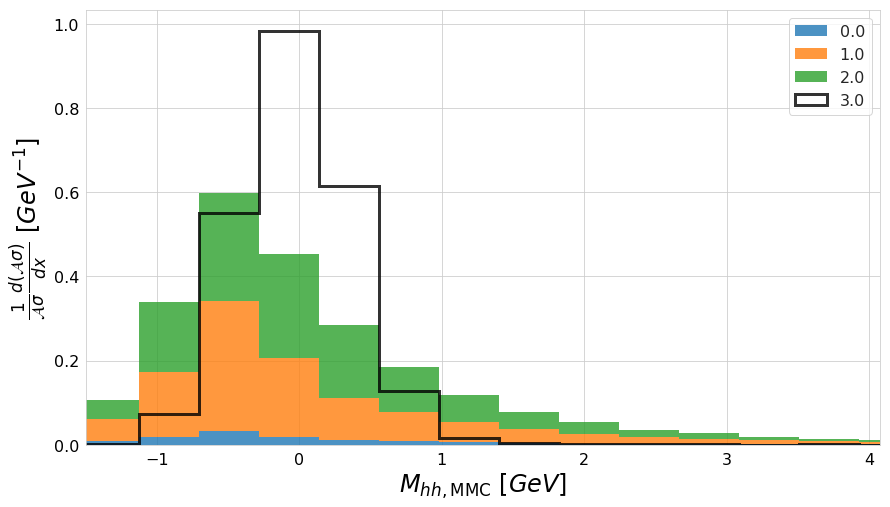

In [23]:
from lumin.plotting.data_viewing import plot_binary_sample_feat

plot_binary_sample_feat(train_df, 'DER_mass_MMC', sample_name='gen_sample', bins=50,
                        lim_x=np.percentile(train_df.DER_mass_MMC.replace([np.inf,-np.inf],np.nan).dropna(),(1,99)),
                        feat_name=r'$M_{hh,\mathrm{MMC}}$', units='GeV', density=True, log_y=False)

### Weight processing
The data contains weights which are important to consider as they indicate which events are the most important to consider and are necessary to correctly compute the AMS at the end. However the data also contains an imbalance between the classes in terms of raw event numbers. We can correct for this imbalance by renormalising the weights such that the sum for each class is equal, however since we might also want to compute the AMS on the training data, we'll make a copy of the column first.

In [24]:
train_df['gen_orig_weight'] = train_df['gen_weight']
for s in set(train_df.gen_sample):
    train_df.loc[train_df.gen_sample == s, 'gen_weight'] /= np.sum(train_df.loc[train_df.gen_sample == s, 'gen_weight'])
train_df.gen_weight.sum()

4.0

### Conversion to fold file 

Having finished processing the data, we can now save it to h5py files in a format that `FoldYielder` will expect.

In [25]:
targ_feat = 'gen_sample'

In [26]:
from lumin.data_processing.file_proc import df2foldfile

df2foldfile(df=train_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats=targ_feat,
            wgt_feat=wgt_feat, misc_feats=misc_feats+['gen_orig_weight', 'gen_target'],
            savename=PATH/'train', targ_type='float32', strat_key='gen_strat_key')

Saving fold 0 with 20000 events
Saving fold 1 with 20000 events
Saving fold 2 with 20000 events
Saving fold 3 with 20000 events
Saving fold 4 with 20000 events
Saving fold 5 with 20000 events
Saving fold 6 with 20000 events
Saving fold 7 with 20000 events
Saving fold 8 with 20000 events
Saving fold 9 with 20000 events


In [27]:
df2foldfile(df=val_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats=targ_feat,
            wgt_feat=wgt_feat, misc_feats=misc_feats+['gen_target'],
            savename=PATH/'val', targ_type='float32', strat_key='gen_strat_key')

Saving fold 0 with 5000 events
Saving fold 1 with 5000 events
Saving fold 2 with 5000 events
Saving fold 3 with 5000 events
Saving fold 4 with 5000 events
Saving fold 5 with 5000 events
Saving fold 6 with 5000 events
Saving fold 7 with 5000 events
Saving fold 8 with 5000 events
Saving fold 9 with 5000 events


In [28]:
df2foldfile(df=test, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats='gen_target',
            wgt_feat=wgt_feat, misc_feats=misc_feats+['private'],
            savename=PATH/'test', targ_type='float32')

Saving fold 0 with 55000 events
Saving fold 1 with 55000 events
Saving fold 2 with 55000 events
Saving fold 3 with 55000 events
Saving fold 4 with 55000 events
Saving fold 5 with 55000 events
Saving fold 6 with 55000 events
Saving fold 7 with 55000 events
Saving fold 8 with 55000 events
Saving fold 9 with 55000 events


## Feature selection

Currently we're using all of the available information from the ROOT file, however it contains an awful lot of high-level features which may not be useful for the regression. We can run a few checks to try and filter out the uneeded features. For a more in depth look into feature selection check out the `Feature_Selection.ipynb` example.

`FoldYielder` is the base class we'll use to pull data from the h5py file. We can also recover the original dataframe via `get_df`, and de-process it by adding the input pipe.

In [29]:
from lumin.nn.data.fold_yielder import FoldYielder

train_fy = FoldYielder(PATH/'train.hdf5', input_pipe=input_pipe)
train_df = train_fy.get_df(inc_inputs=True, deprocess=True, nan_to_num=True); train_df.head()

200000 datapoints loaded


/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:391: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_subleading_px,PRI_jet_subleading_py,PRI_jet_subleading_pz,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,140.253006,0.511000,94.819000,58.858002,0.0,0.0,0.0,2.944,31.768000,112.776001,...,0.0,0.0,0.0,16.736324,-46.021259,-138.398346,27.697001,1.0,3.0,0.000003
1,0.000000,87.121002,64.459000,0.985002,0.0,0.0,0.0,2.080,0.985000,63.266998,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,49.791000,0.0,2.0,0.000030
2,124.153000,19.144001,89.551003,4.102998,0.0,0.0,0.0,2.825,4.103001,92.165001,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,20.224001,0.0,3.0,0.000034
3,155.311005,44.717999,117.090996,4.419000,0.0,0.0,0.0,3.316,4.419001,88.903000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,11.017001,0.0,1.0,0.000018
4,0.000000,117.401001,64.094002,1.538999,0.0,0.0,0.0,1.939,1.539001,83.329002,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,58.528000,0.0,1.0,0.000018


We'll also want to split off another, temporary validation set

In [30]:
df_trn, df_val = train_test_split(train_df, test_size=0.2)

We're mainly interested in filtering down the high-level features, and will assume that the random forests we'll be using will not be able to make as much use of the lower level information as the neural networks will, so we'll only test the high level features and add regularisation as necessary later.

In [31]:
vec_feats = []
for c in ['px', 'py', 'pz', 'mass']:
    vec_feats += [f for f in train_feats if f == f'{f[:f.rfind("_")+1]}{c}']
len(vec_feats)

14

In [32]:
hl_feats = [f for f in train_feats if f not in vec_feats]; len(hl_feats)

17

Let's see which of the high-level features the RFs find useful. `rf_rank_features` wraps rfpimp and initially trains a RF using the data and evaluates it on the validation set. It then sequentially makes a copy of the data and randomises the order of one of the features and then reevaluates the model performance, and compares it to the original score. If their is a large decrease in the score, then the feature which was randomised was very important in the model. If there is only a small decrease (or increase) in the score, then the feature was not important. 

Having established the importance of the features, `rf_rank_features` then runs another training only using the features with importances higher the the `cut` argument. If there is no decrease in the score, the ignored features can probably be safely removed.

Optimising RF parameters


Evalualting importances


Top ten most important features:
                         Feature  Importance
0                PRI_jet_all_pt    0.107967
2   DER_mass_transverse_met_lep    0.085415
1                  DER_mass_MMC    0.072082
3                    DER_pt_tot    0.039431
4                  DER_mass_vis    0.027115
7              DER_mass_jet_jet    0.026010
6          DER_pt_ratio_lep_tau    0.022459
5                    PRI_met_pt    0.020734
8            DER_deltar_tau_lep    0.019906
10                PRI_met_sumet    0.016972


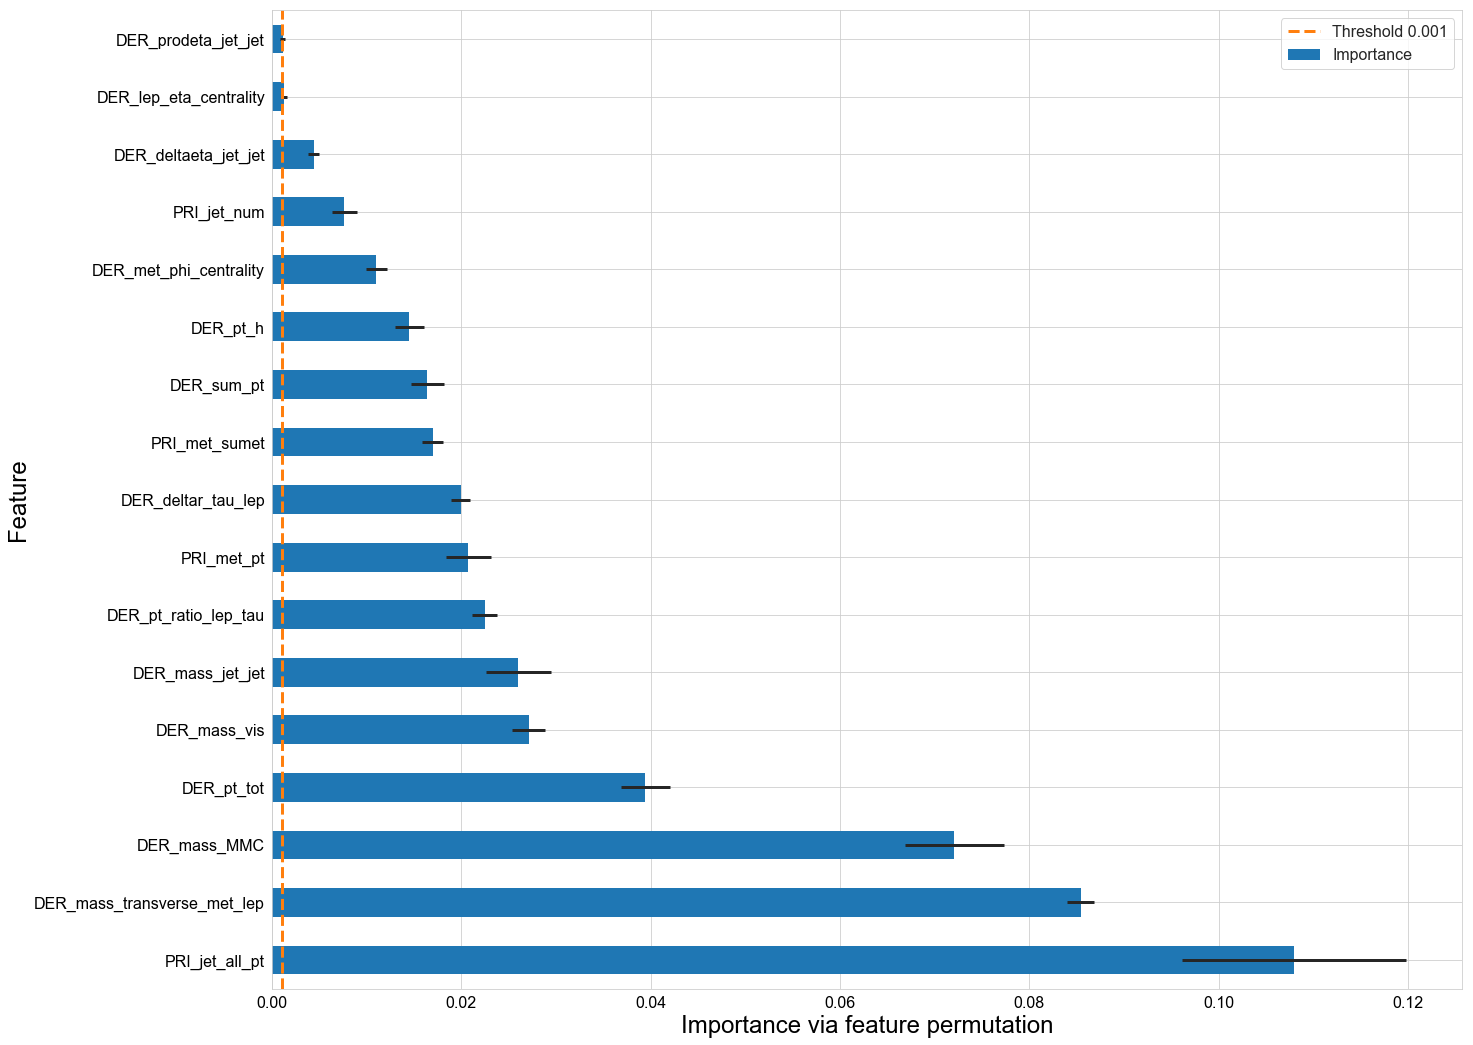


17 features found with importance greater than 0.001:
 ['PRI_jet_all_pt', 'DER_mass_transverse_met_lep', 'DER_mass_MMC', 'DER_pt_tot', 'DER_mass_vis', 'DER_mass_jet_jet', 'DER_pt_ratio_lep_tau', 'PRI_met_pt', 'DER_deltar_tau_lep', 'PRI_met_sumet', 'DER_sum_pt', 'DER_pt_h', 'DER_met_phi_centrality', 'PRI_jet_num', 'DER_deltaeta_jet_jet', 'DER_lep_eta_centrality', 'DER_prodeta_jet_jet'] 

All training features found to be important


In [33]:
from lumin.optimisation.features import rf_rank_features
import_feats = rf_rank_features(df_trn, df_val, objective='classification', train_feats=hl_feats,
                                importance_cut=0.001, n_rfs=5, wgt_name='gen_weight')

## Train classifier

Now we're ready to begin training the network-based classifier.

### Data augmentation
We'll load the data using a specialised `FoldYielder` designed to provide the event rotations we want.

In [34]:
from lumin.nn.data.fold_yielder import HEPAugFoldYielder

train_fy = HEPAugFoldYielder(PATH/'train.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


During training, this will randomly rotate the event in phi, randomly flip it in the y-axis, and randomly flip it in the z-axis. Lets view a few possible examples of the same event.

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


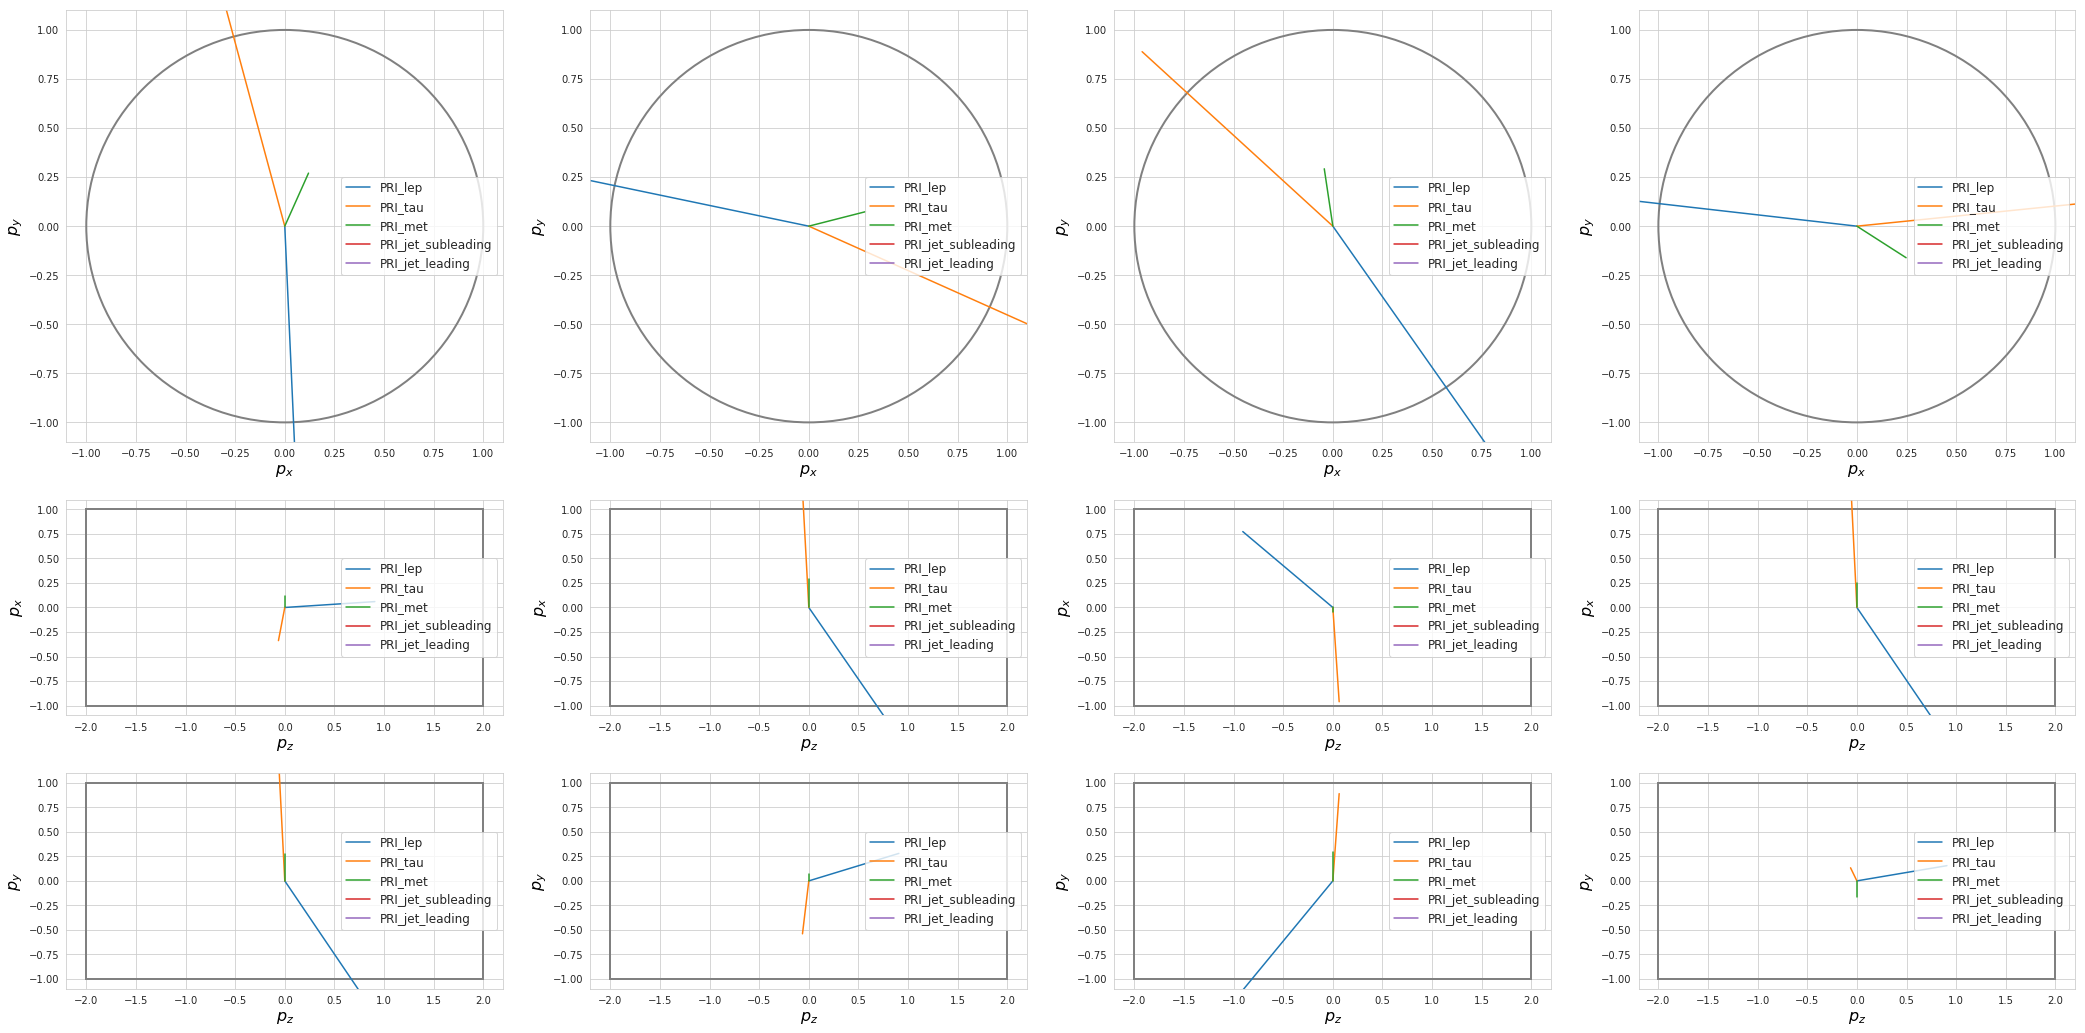

In [35]:
from lumin.plotting.data_viewing import compare_events

idx=3
compare_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[idx:idx+1] for i in range(4)])

During testing it will provide versions of each possible combination of flips for 2 set rotations.

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


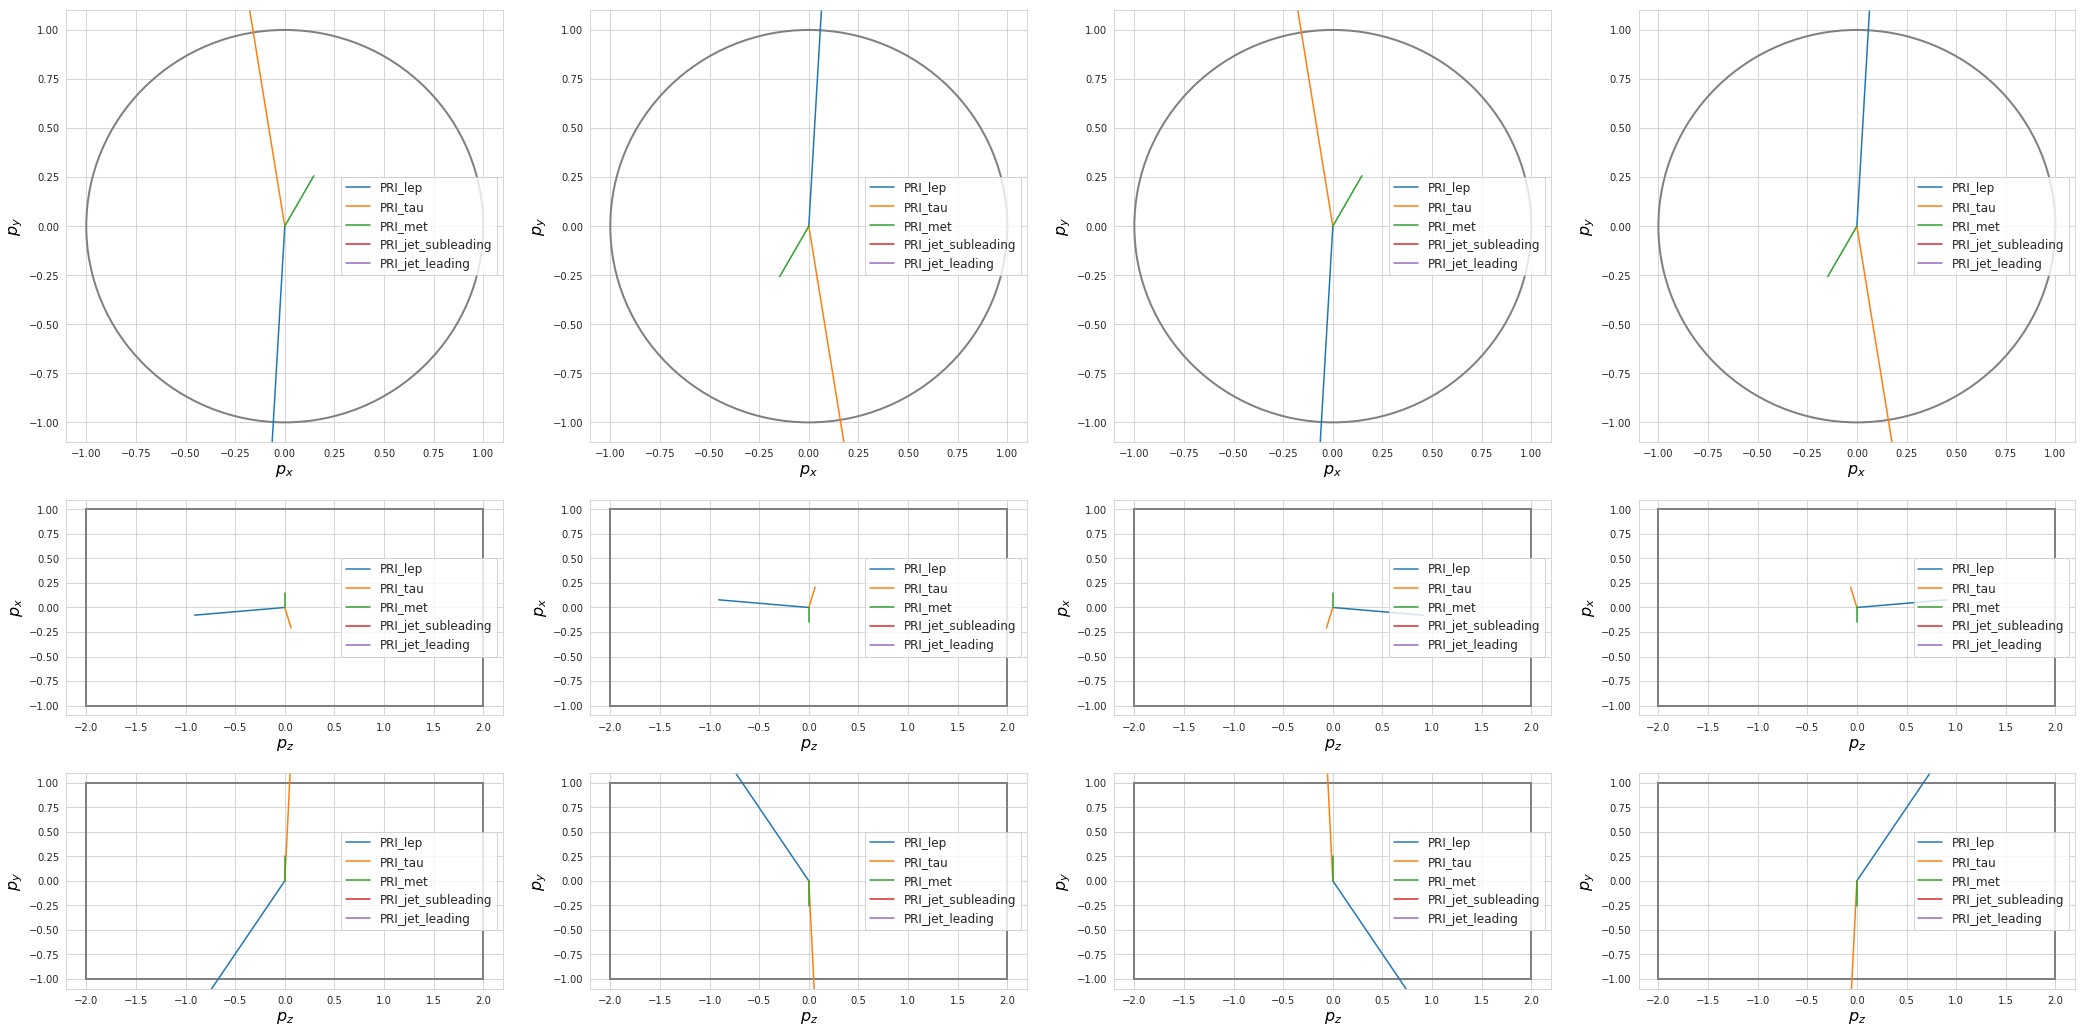

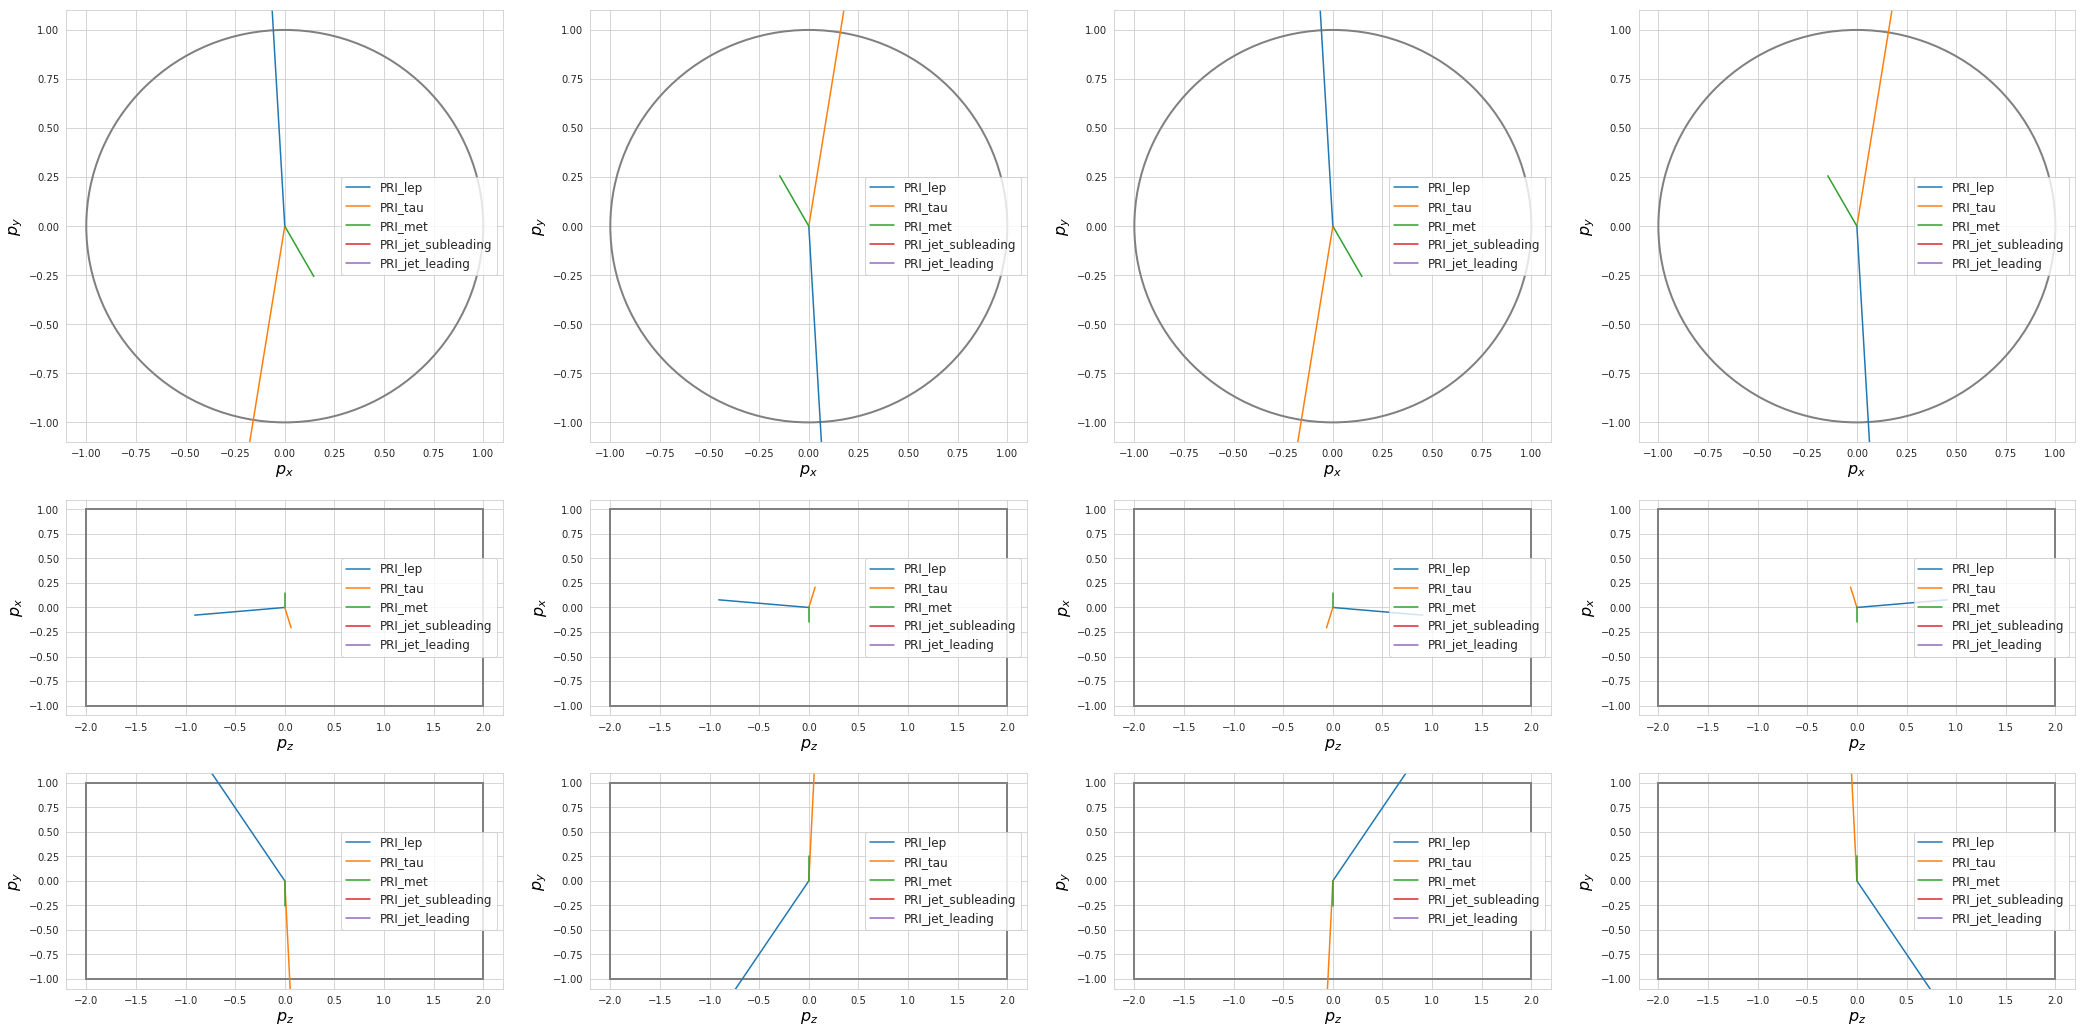

In [36]:
for aug_range in [range(4), range(4,8)]:
    compare_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[idx:idx+1] for i in aug_range])

Here we define the architecture of the models, and how we want to train them. `ModelBuilder` takes arguments to define the network, loss, optimiser, and inputs and outputs and can then create networks on demand. These networks are provided as properties of the `Model` class which contains methods to train them, evaluate, predict, save/load, et cetera.
### ModelBuilder
Most of the parameters will use default values if not provided explicitly which can be viewed in the source code, e.g. `ModelBuilder._parse_loss`, `ModelBuilder._parse_model_args`, and `ModelBuilder._parse_opt_args`.
#### Architecture
The network consists of three parts: A head, which takes the inputs to the network; a body, which contains the majority of the hidden layers; and a tail which downscales the output of the body to match the desired number of outputs. The classes used for each can be specified 

By default the head is `CatEmbHead` which provides [entity embeddings](https://arxiv.org/abs/1604.06737) for categorical features (embedding sizes can be configured manually, or left as default `max(50,cardinality//2)`), and then a batch normalisation with the continuous inputs, with separate dropouts for embeddings and continuous inputs. More advanced classes, can be passed to the `ModelBuilder` head argument, or `ModelBuilder.get_head` overridden in an inheriting class. An `CatEmbedder` class is needed to provide the necessary parameters for the embeddings. They can either be instantiated from the training `FoldYielder`, or by manually providing the required information.

The default body is a simple sequence of hidden layers (`FullyConnected`). These layers can optionally have dropout, batch normalisation, skip connections (residual network), or cumulative concatenations (dense network). The choice of class is set by `ModelBuldier`'s `body` argument, and built by `ModelBuilder.get_body`.

The tail (default `ClassRegMulti` set by `tail` argument/`ModelBuilder.get_tail`) uses a final dense layer to scale down the body output to match `n_out` and then applies an automatically selected activation according to `objective`:
- 'class*' or 'labelclass*' = sigmoid
- 'multiclass' = logsoftmax
- 'regression' and not `y_range` = linear
- 'regression' and `y_range` = sigmoid + offset and rescaling
#### Loss
This can either be passed as the `loss` argument of `ModelBuilder`, or be left to be automatically chosen according to `objective`:
- 'class*' or 'labelclass*' = Binary cross-entropy (`nn.BCELoss`)
- 'multiclass' = Weighted cross-entropy (`WeightedCCE`)
- 'regression' = Weighted mean-squared error (`WeightedMSE`, (`WeightedMAE` also exists but must be explicitly passed))

**N.B.** If a loss class is passed explicitly, it should be uninitialised to allow weights to be correctly handled.

`ModelBuilder.parse_loss` handles the automatic loss configuration.
#### Optimiser
Configured by `opt_args` argument of `ModelBuilder`, `ModelBuidler._parse_opt_args`, and `ModelBuilder._build_opt`. Currently only SGD and Adam are available by passing string representations, however more exotic optimisers can be set by passing uninstanciated classes as the `opt_args['opt']` parameter. Choices of weight decay should be added in `opt_args`. The Learning rate can be set later via `ModelBuilder.set_lr`.es of weight decay should be added in `opt_args`. The Learning rate can be set later via `ModelBuilder.set_lr`.

#### Architecture
For our example architecture we'll use SELU-based 4-layer network of width 100. We'll also load in the embedding weights for the jet multiplicity which were learnt during the binary classification example (`'emb_load_path':Path('weights')` in `cat_args`).

In [37]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
import torch.nn as nn
from lumin.nn.models.helpers import CatEmbedder

bs = 256
objective = 'multiclass_classifier'
model_args = {'body':{'act':'selu', 'width':100, 'depth':4}}
opt_args = {'opt':'adam', 'eps':1e-08}
cat_embedder = CatEmbedder.from_fy(train_fy, emb_load_path=Path('weights'))

n_out = 4
model_builder = ModelBuilder(objective, cont_feats=cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, opt_args=opt_args)
Model(model_builder)

Loading embedings: {0: 'weights/PRI_jet_num.h5'}


Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=32, out_features=100, bias=True)
        (1): SELU

The learning rate can be quickly optimised via the [LR range test](https://arxiv.org/abs/1506.01186). This involves gradually increasing the LR from a small value to a lrage one after each minibatch update and then plotting the loss as a function of the LR. One can expect to see an initial period of slow, or nonexistant, loss decrease where the LR is far too small. Eventully the LR becomes large enough to allow useful weigh updates (loss decreases). Eventually the LR becomes so large the network diverges (loss platues then increases). The optimal LR is the highest one at which the loss is still decreasing.

To allow for the randomness between different network trainings and data, `lr_find`, runs several trainings using different folds of the data and then plots the mean and standard deviation of the loss.

Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
Loading embedings: {0: 'weights/PRI_jet_num.h5'}
LR finder took 27.519s 


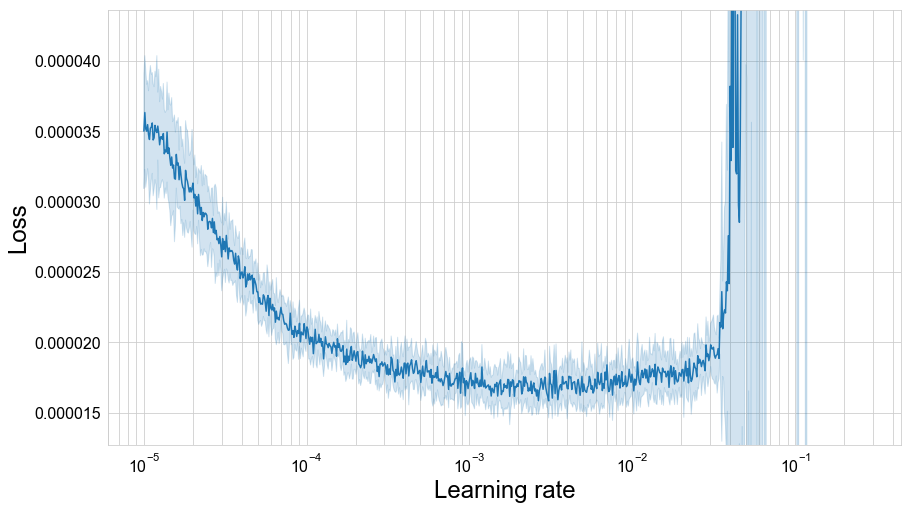

In [38]:
from lumin.optimisation.hyper_param import lr_find

lr_finder = lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e-1], train_on_weights=True)

Looks like somewhere around 2e-3 should be good.

The training function takes several sets of callbacks, ways to alter the model's training schedule, to report more specialised results, to affect the earlystopping, and to keep track of model weights.

For this example we'll train an ensemble of 5 models trained using [the 1-cycle policy](https://arxiv.org/abs/1803.09820), with cosine interpolation. Note that the two numbers in the `lengths` parameter for the `OneCycle` class are the number of sub-epochs in the first part of the cycle and the second part, respectively. Early stopping happens automatically after the cycle ends.

We'll also add an evaluation metric to compute the AMS on the validation folds. However, since the classifier is predicting the sample each event belongs to, we need to condense the output back to a binary prediction. Note that we tell the AMS calculation to load the original weights, and tell it the total number of events in the sample. This allows the weights to be rescaled to account for the fact that the AMS will be calculated only on the validation folds, which are much smaller than the full training sample. `br=10` is a factor included in the HiggsML competition.

However unlike in other examples where we could confidently select models according to the metric computed on the validation data, the AMS really needs to computed on a large sample to be accurate, otherwise it is subject to statistical fluctuations. I.e. we want to ensure that early stopping and save best are computed using the loss but we still want to compute the AMS. Do do this, we can set `main_metric` to `False`.

In [39]:
from lumin.nn.callbacks.cyclic_callbacks import OneCycle
from lumin.nn.metrics.class_eval import MultiAMS
from functools import partial

n_models = 3
patience = 2
n_epochs = 15

cb_partials = [partial(OneCycle, lengths=[5, 10], lr_range=[2e-5, 2e-3], mom_range=[0.85, 0.95], interp='cosine')]
metric_partials = [partial(MultiAMS, n_total=250000, br=10,
                           zero_preds=['pred_0', 'pred_1', 'pred_2'], one_preds=['pred_3'],
                           targ_name='gen_target', wgt_name='gen_orig_weight', main_metric=False)]

`train_models` performs training of (an ensemble of) models produced by the `ModelBuilder` using data provided by a `FoldYielder`. Model training  runs for upto `max_epochs` number of epochs, or until `patience` number of sub-epochs (or cycles) have elapsed with out an improvment of the validation loss. The model is then saved to `saveloc` to be loaded later. The function returns results of the training and model perfomance on validation fold. If an `AbsCyclicCallback` is used, then snapshots of the model weights are automatically saved after each cycle to allow for [Snapshot Ensembling](https://arxiv.org/abs/1704.00109) or [Fast Geometric Ensembling](https://arxiv.org/abs/1802.10026).

Training model 1 / 3, Val ID = 0
Loading embedings: {0: 'weights/PRI_jet_num.h5'}


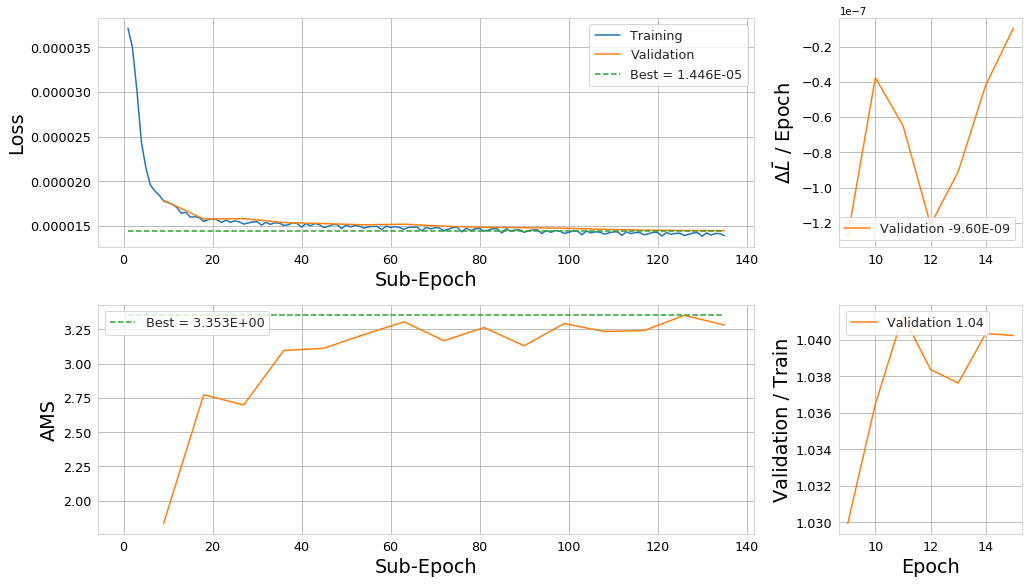

Loading best model with metric value 1.446E-05
Model took 53.408s

Scores are: {'loss': 1.446085843781475e-05, 'AMS': 3.28216142184411}
Training model 2 / 3, Val ID = 1
Loading embedings: {0: 'weights/PRI_jet_num.h5'}


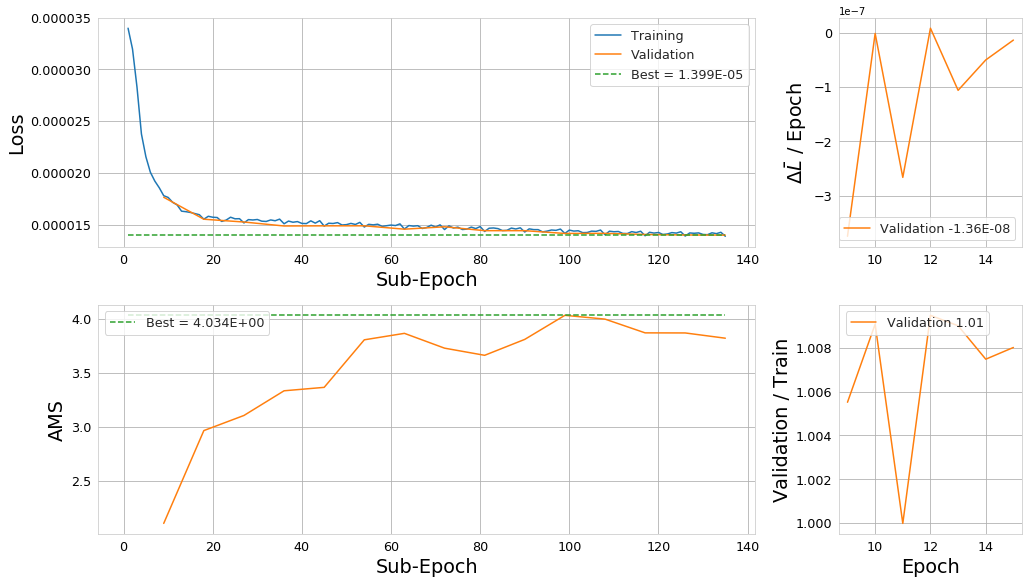

Loading best model with metric value 1.399E-05
Model took 53.526s

Scores are: {'loss': 1.3989747458253987e-05, 'AMS': 3.8215630894883303}
Training model 3 / 3, Val ID = 2
Loading embedings: {0: 'weights/PRI_jet_num.h5'}


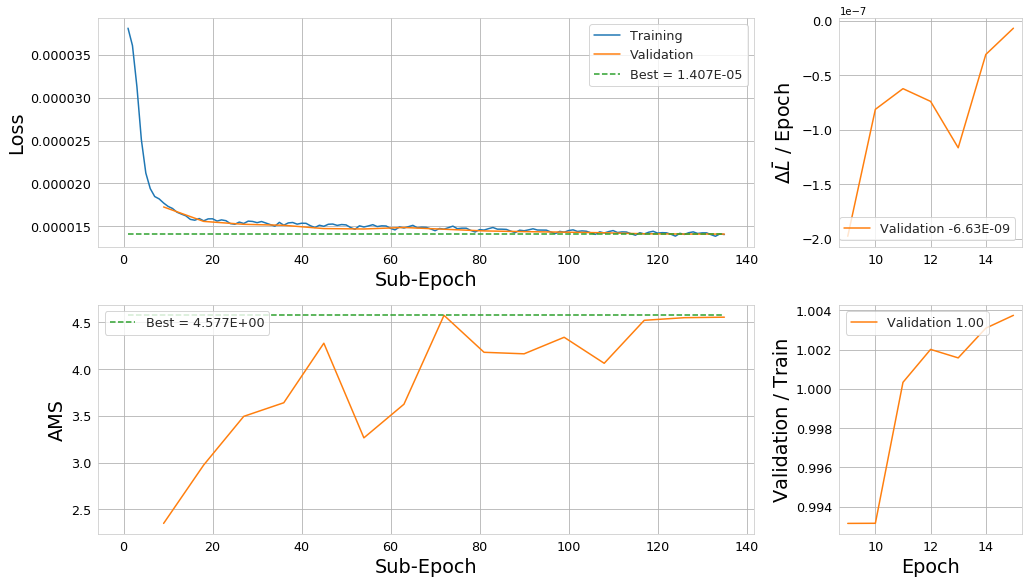

Loading best model with metric value 1.407E-05
Model took 54.403s

Scores are: {'loss': 1.4067354641156271e-05, 'AMS': 4.55679207834177}

______________________________________
Training finished
Cross-validation took 161.520s 


<Figure size 1024x576 with 0 Axes>

<Figure size 1024x576 with 0 Axes>

<Figure size 1024x576 with 0 Axes>

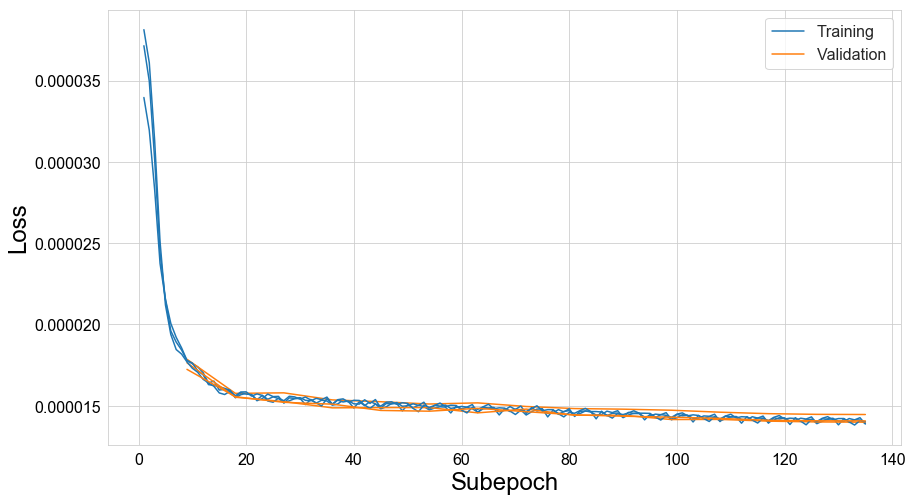

Mean loss = 1.42e-05±1e-07
Mean AMS = 3.9±0.3
______________________________________



In [45]:
from lumin.nn.training.train import train_models

results, histories, cycle_losses = train_models(train_fy,  # Training data
                                                n_models,  # Number of models to train
                                                model_builder=model_builder,  # How to build models, losses, and optimisers
                                                bs=bs,  # Batch size
                                                cb_partials=cb_partials,  # List of uninitialised callbacks
                                                metric_partials=metric_partials,  # Pass our evaluation metrics
                                                n_epochs=n_epochs,  # Maximum number of epochs to train
                                                patience=patience)  # If not None, stop training if validation loss doesn't improve after set number of epochs (automatic save best)

## Ensemble loading
We can now build an ensemble from the trained models, however rather than simply treating them all equally, we can weight them according to some metric (e.g. AMS, reciprocal of loss).

In [46]:
with open('train_weights/results_file.pkl', 'rb') as fin: results = pickle.load(fin)

In [47]:
model_builder.cat_embedder.emb_load_path = None  # Don't load old embedding weights

In [48]:
from lumin.nn.ensemble.ensemble import Ensemble

ensemble = Ensemble.from_results(results, n_models, model_builder, metric='loss')

Choosing ensemble by loss


Model 0 is 1 with loss = 1.3989747458253987e-05
Model 1 is 2 with loss = 1.4067354641156271e-05
Model 2 is 0 with loss = 1.446085843781475e-05


The default location is likely to be overwritten, so we can save it to a more permanent location.

In [49]:
name = 'weights/Multiclass_Classification'
ensemble.save(name, feats=train_feats, overwrite=True)

## Validation without TTA
Now we can test how well our ensemble performs on our validation set. We'll run first without test-time data augmentation (TTA).

In [50]:
from lumin.nn.data.fold_yielder import FoldYielder

val_fy = FoldYielder(PATH/'val.hdf5', cont_feats, cat_feats)

/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:153: UserWarning: Fold file contains meta data information, explicit passing of continuous and categorical feature lists is no longer required.
  warnings.warn("Fold file contains meta data information, explicit passing of continuous and categorical feature lists is no longer required.")


In [51]:
ensemble.predict(val_fy)

Remember we need to load the original class for the target, rather than the sample. We can then use `to_binary_class` to map the sample predictions to signal and background:
- sample = argmax pred_*
- pred = pred if sample == signal else 1-pred

In [52]:
from lumin.utils.misc import to_binary_class

val_df = val_fy.get_df(targ_name='gen_target')
to_binary_class(val_df, ['pred_0', 'pred_1', 'pred_2'], ['pred_3']); val_df.head()

50000 datapoints loaded


,gen_target,gen_weight,pred_0,pred_1,pred_2,pred_3,pred
0,0,4.936269,0.003044,0.161338,0.772853,0.062765,0.227147
1,0,1.681611,0.008074,0.498795,0.226910,0.266220,0.501205
2,1,0.001503,0.048275,0.000273,0.000003,0.951449,0.951449
3,1,0.001503,0.126649,0.335618,0.010005,0.527728,0.527728
4,0,1.945040,0.114612,0.757977,0.089098,0.038313,0.242023


In the HiggsML challenge, prediction on the test set requires specifying whether each event is signal or background, meaning we need to apply a cut on our class prediction. We could simply scan across the events in the validation sample and see where the AMS is maximised, (not we apply a weight factor to account for the difference between our validation sample and the full training sample):

In [53]:
from lumin.evaluation.ams import ams_scan_slow
ams_scan_slow(val_df, br=10, wgt_factor=250000/50000, start_cut=0.8)

(3.87263488507097, 0.8584026)

A maximum AMS of 3.872 for a cut of 0.85; not as good a result as we had for the binary classification version, but it's still an interesting approach and this only meant to be an example of multiclass classification anyway.

The maximum AMS is a tricky metric that can easily be affected by statistical fluctuations due to limited data. It is extremely likely that event though we are getting this result on unseen data, it will not generalise very well. Instead we want to try and capture the general trend of the AMS and place our cut in the approximate region of high performance, rather than picking exactly where the AMS happened to maximise on our data. I've experimented with numerous approaches (bootstrap resampling, cross-validation, KDEs, et cetera) and found that so far the most generalising method is to rank points by events by their AMS, and then take the mean prediction of the top few percent as the cut.

Mean cut at 0.8517652153968811 corresponds to AMS of 3.834083880406798
Maximum AMS for data is 3.87263488507097 at cut of 0.8584026098251343


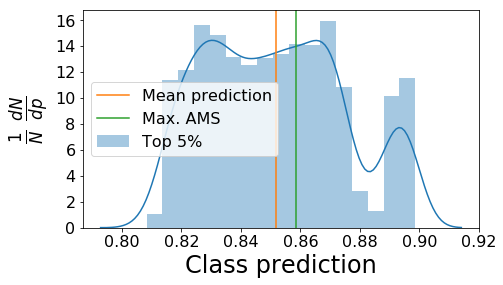

In [54]:
from lumin.optimisation.threshold import binary_class_cut_by_ams

cut, smooth_ams, max_ams = binary_class_cut_by_ams(val_df, min_pred=0.8, top_perc=5, br=10, wgt_factor=250000/50000)

So, the AMS has dropped from 3.87 to 3.83, but hopefully the cut might generalise better to the test data

## Validation with TTA
Now we'll see whether TTA can improve our result.

In [55]:
val_fy = HEPAugFoldYielder(PATH/'val.hdf5', rot_mult=2, input_pipe=input_pipe)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


Note that prediction using `HEPAugFoldYielder` predicts each event 8 times, once on each augmented version, and takes the average. We'll also specify a name for the prediction to saved under to avoid overwriting the non-TTA predictions.

In [56]:
ensemble.predict(val_fy, pred_name='pred_TTA')

In [57]:
val_df_tta = val_fy.get_df(pred_name='pred_TTA', targ_name='gen_target')
to_binary_class(val_df_tta, [f'pred_{i}' for i in range(3)], ['pred_3']); val_df_tta.head()

50000 datapoints loaded


,gen_target,gen_weight,pred_0,pred_1,pred_2,pred_3,pred
0,0,4.936269,0.003165,0.171372,0.763045,0.062417,0.236955
1,0,1.681611,0.008143,0.497517,0.230320,0.264020,0.502483
2,1,0.001503,0.042299,0.000261,0.000003,0.957437,0.957437
3,1,0.001503,0.124699,0.345560,0.008874,0.520866,0.520866
4,0,1.945040,0.112420,0.761674,0.088739,0.037167,0.238326


Mean cut at 0.8503062725067139 corresponds to AMS of 3.796731919893855
Maximum AMS for data is 3.841671749208577 at cut of 0.8461350798606873


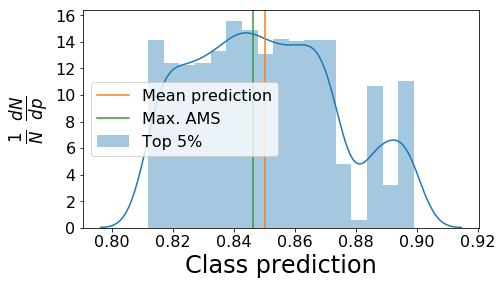

In [58]:
cut_tta, smooth_ams_tta, max_ams_tta = binary_class_cut_by_ams(val_df_tta, min_pred=0.8, top_perc=5, br=10,
                                                               wgt_factor=250000/50000)

Slight change when we run TTA. We can also plot the prediction distribution:

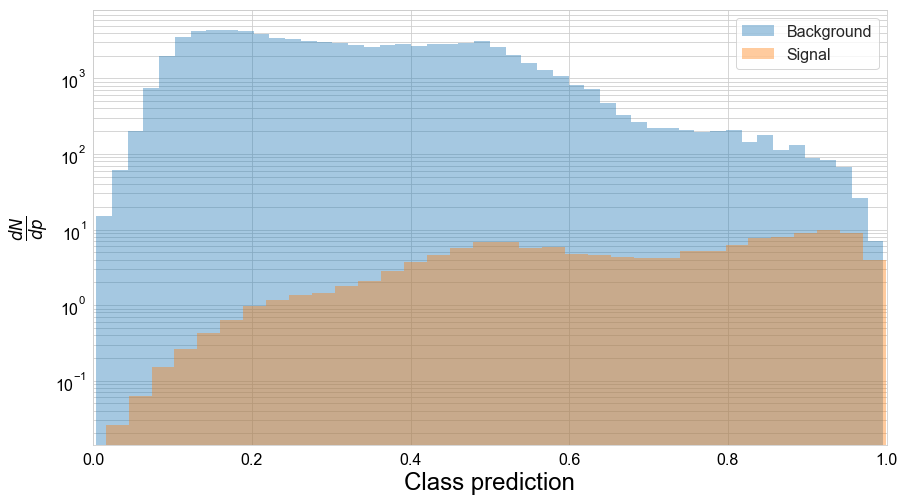

In [59]:
from lumin.plotting.results import plot_binary_class_pred

plot_binary_class_pred(val_df_tta, wgt_name='gen_weight', density=False, log_y=True)

## Plotting
In a real HEP search, one might well wish to instead plot the discriminant split by sample. We'll load up the samples, rename them to something more meaningful (just guessing the order I'm afraid), and use `plot_sample_pred` to get a more flexible histogram.

In [60]:
val_df_tta['gen_sample'] = val_fy.get_column('targets'); val_df_tta.head()

,gen_target,gen_weight,pred_0,pred_1,pred_2,pred_3,pred,ams,gen_sample
0,0,4.936269,0.003165,0.171372,0.763045,0.062417,0.236955,-1.000000,2.0
1,0,1.681611,0.008143,0.497517,0.230320,0.264020,0.502483,-1.000000,1.0
2,1,0.001503,0.042299,0.000261,0.000003,0.957437,0.957437,2.759153,3.0
3,1,0.001503,0.124699,0.345560,0.008874,0.520866,0.520866,-1.000000,3.0
4,0,1.945040,0.112420,0.761674,0.088739,0.037167,0.238326,-1.000000,1.0


In [61]:
samples = [x[0] for x in np.array(sorted(zip(range(3), [val_df_tta.loc[val_df_tta['gen_sample']==y, 'gen_weight'].sum() for y in range(3)]), key=lambda x: x[1]))]
for i, s in enumerate(samples):
    if   i == 0: val_df_tta.loc[val_df_tta['gen_sample']==s, 'gen_sample'] = r'$W$-boson'
    elif i == 1: val_df_tta.loc[val_df_tta['gen_sample']==s, 'gen_sample'] = r'$Z\rightarrow\tau\bar{\tau}$'
    elif i == 2: val_df_tta.loc[val_df_tta['gen_sample']==s, 'gen_sample'] = r'$t\bar{t}$'
val_df_tta.loc[val_df_tta['gen_sample']==3, 'gen_sample'] = r'Signal: $H\rightarrow\tau\bar{\tau}$'
val_df_tta.head()

,gen_target,gen_weight,pred_0,pred_1,pred_2,pred_3,pred,ams,gen_sample
0,0,4.936269,0.003165,0.171372,0.763045,0.062417,0.236955,-1.000000,$t\bar{t}$
1,0,1.681611,0.008143,0.497517,0.230320,0.264020,0.502483,-1.000000,$Z\rightarrow\tau\bar{\tau}$
2,1,0.001503,0.042299,0.000261,0.000003,0.957437,0.957437,2.759153,Signal: $H\rightarrow\tau\bar{\tau}$
3,1,0.001503,0.124699,0.345560,0.008874,0.520866,0.520866,-1.000000,Signal: $H\rightarrow\tau\bar{\tau}$
4,0,1.945040,0.112420,0.761674,0.088739,0.037167,0.238326,-1.000000,$Z\rightarrow\tau\bar{\tau}$


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


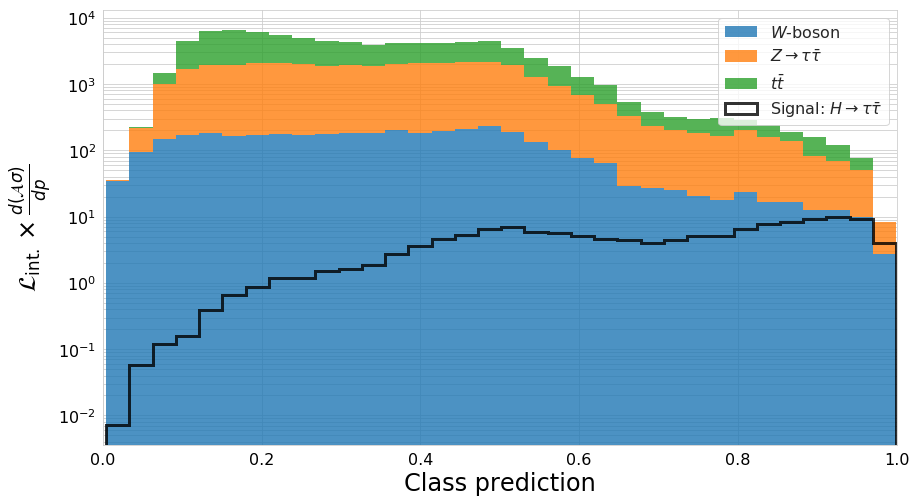

In [62]:
from lumin.plotting.results import plot_sample_pred

plot_sample_pred(val_df_tta)

Although not required for the HiggsML challenge, rather than simply cutting on the class prediction to get a signal bin for the signal hypothesis test (cut & count), one could instead use the shape of the distributions (shape analysis). The power of the analysis can be expected to increase with the number of bins used to capture the shape of the distributions, however one must consider the uncertainties on the bin fills due to limited Monte Carlo data being used to populate them. We can use `bin_binary_class_pred` to optimise the bin edges such that the uncertainty on the normalisation per bin per sample is kept below a specified percentage:

In [63]:
from lumin.inference.summary_stat import bin_binary_class_pred

edges = bin_binary_class_pred(val_df_tta, max_unc=0.15)
print(len(edges)-1, 'bins, with edges:', edges)

88 bins, with edges: [0.    0.066 0.118 0.142 0.16  0.176 0.192 0.202 0.214 0.226 0.234 0.244
 0.254 0.263 0.27  0.277 0.284 0.292 0.299 0.308 0.316 0.323 0.329 0.335
 0.343 0.349 0.354 0.359 0.364 0.37  0.375 0.379 0.384 0.389 0.394 0.398
 0.402 0.406 0.41  0.414 0.419 0.423 0.427 0.431 0.435 0.439 0.443 0.447
 0.451 0.455 0.459 0.463 0.467 0.471 0.475 0.479 0.483 0.486 0.489 0.493
 0.496 0.499 0.503 0.508 0.512 0.515 0.52  0.524 0.529 0.534 0.539 0.544
 0.551 0.556 0.563 0.569 0.577 0.583 0.592 0.6   0.61  0.624 0.637 0.655
 0.693 0.742 0.793 0.858 1.   ]


We can now pass these edges to our plotting function:

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


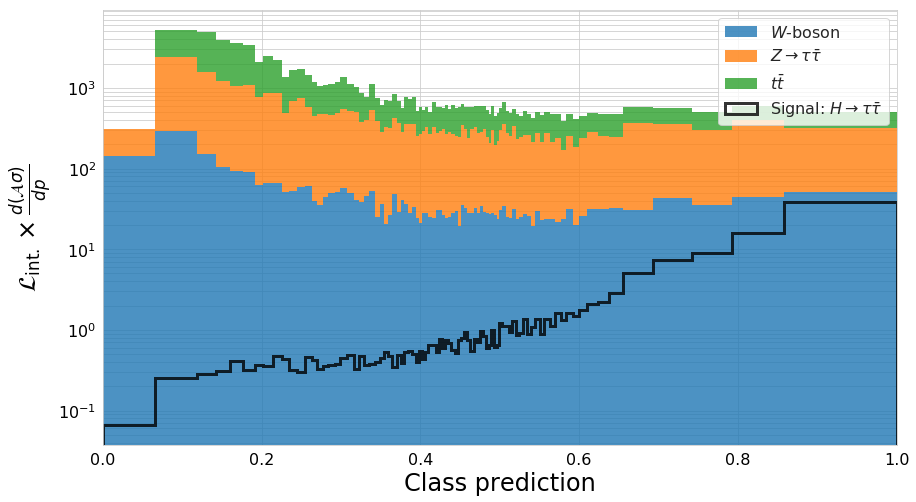

In [64]:
plot_sample_pred(val_df_tta, bins=edges)

Probably not necessary here, but just to show it off, we can set a plot title and zoom into sections of the distribution:

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


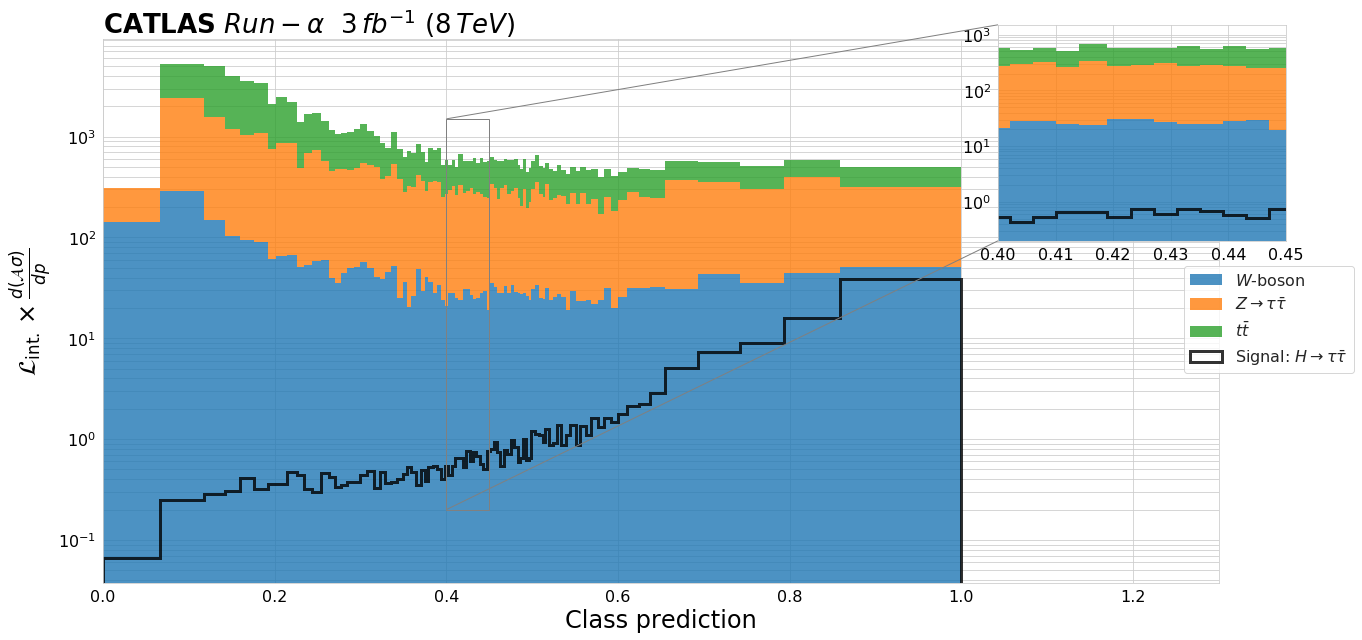

In [65]:
from lumin.plotting.plot_settings import PlotSettings

settings = PlotSettings(w_mid=20, h_mid=10, title=r'$\mathbf{CATLAS}\ \mathit{Run}-\alpha$' + '\t' + r'$3\,fb^{-1}\ (8\, TeV)$')
plot_sample_pred(val_df_tta, bins=edges, settings=settings, lim_x=(0,1.3),
                 zoom_args={'x':(0.4,0.45), 'y':(0.2, 1500), 'anchor':(0,0.25,0.95,1),
                            'width_scale':1, 'width_zoom':4, 'height_zoom':3})

## Interpretation 
It could be interesting to see what the multiclass approach learns differently to the binary classification method.

### Feature importance
In the same way as we used permutation importance to rank features with random forests, we can use the same technique to rank features with our ensemble.

Top ten most important features:
                 Feature  Importance  Uncertainty
0            DER_sum_pt    1.526935     0.028625
1        PRI_jet_all_pt    0.580889     0.010438
2          DER_mass_vis    0.391810     0.011793
3    DER_deltar_tau_lep    0.256649     0.006201
4           PRI_jet_num    0.213053     0.007090
5            PRI_met_pt    0.166041     0.005467
6              DER_pt_h    0.157250     0.005541
7          DER_mass_MMC    0.149459     0.004259
8  DER_pt_ratio_lep_tau    0.122426     0.003767
9            DER_pt_tot    0.110665     0.004424


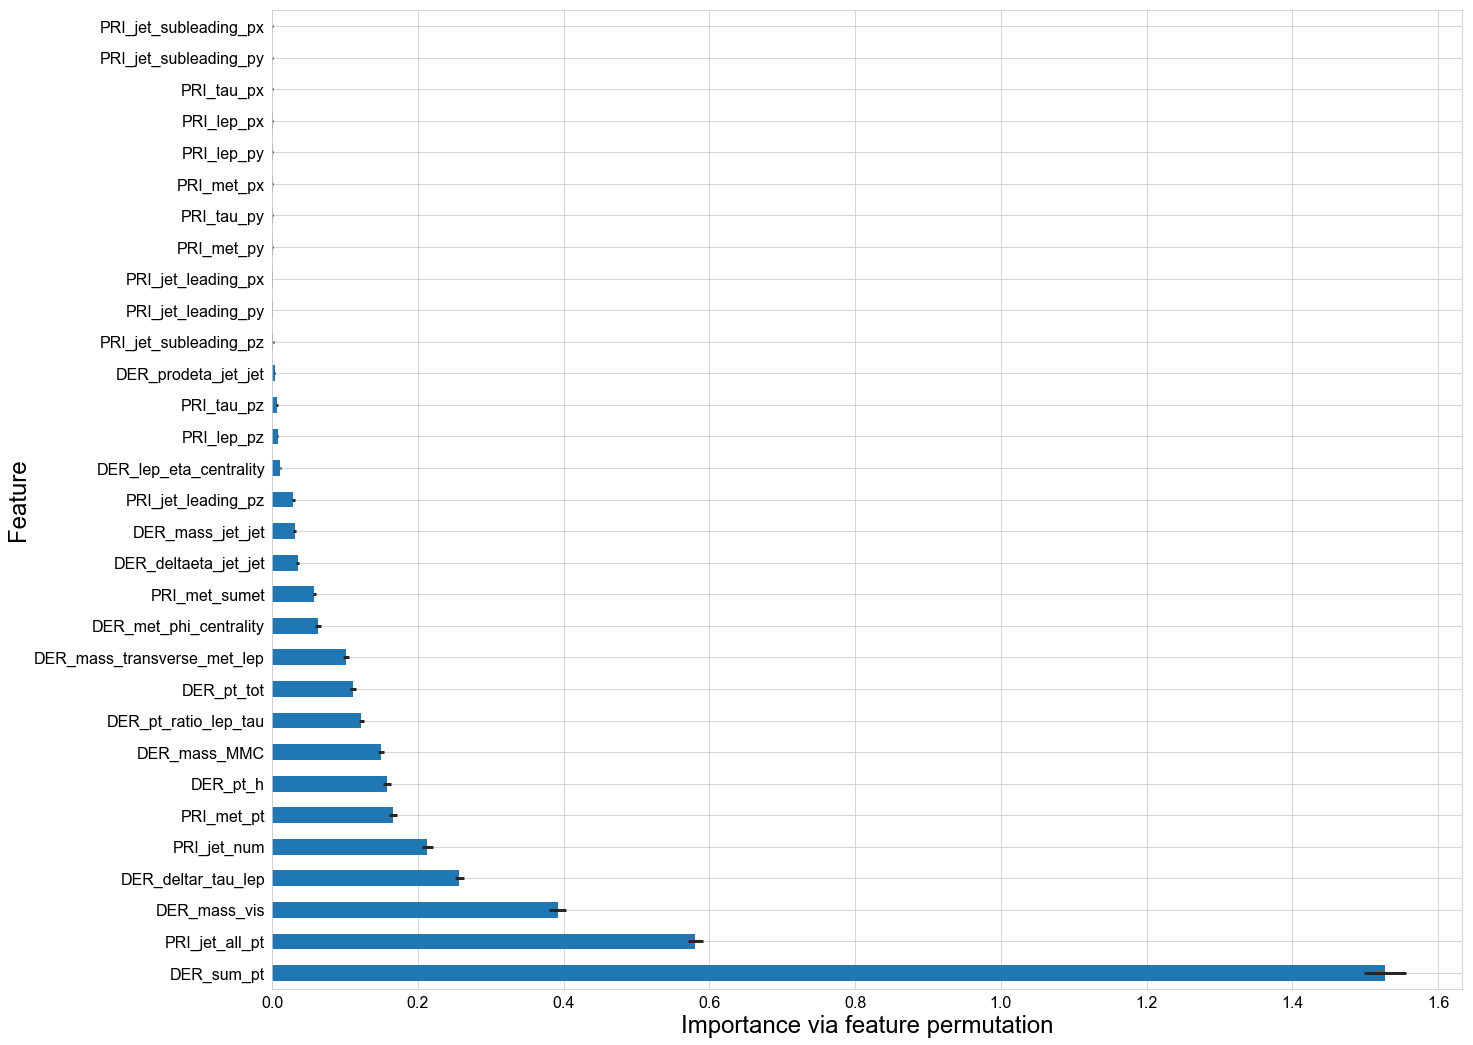

In [66]:
_ = ensemble.get_feat_importance(train_fy)

Interestingly, the ensemble relies on a mixture of high- and low-level features, with a slightly supressed spread of importances.

Currently, we're measuring importance via changes in weighted categorical cross-entropy. Instead we can get the effect on the AMS by passing an `eval_metric`, (this takes a while, though).

Top ten most important features:
                        Feature  Importance  Uncertainty
0                   DER_sum_pt    0.690103     0.021817
1                 DER_mass_vis    0.577179     0.047866
2               PRI_jet_all_pt    0.445733     0.038568
3                 DER_mass_MMC    0.344866     0.042889
4  DER_mass_transverse_met_lep    0.314740     0.064152
5         DER_pt_ratio_lep_tau    0.274780     0.100503
6                   PRI_met_pt    0.217212     0.049750
7                  PRI_jet_num    0.205447     0.089031
8           DER_deltar_tau_lep    0.177718     0.119351
9                     DER_pt_h    0.177648     0.083537


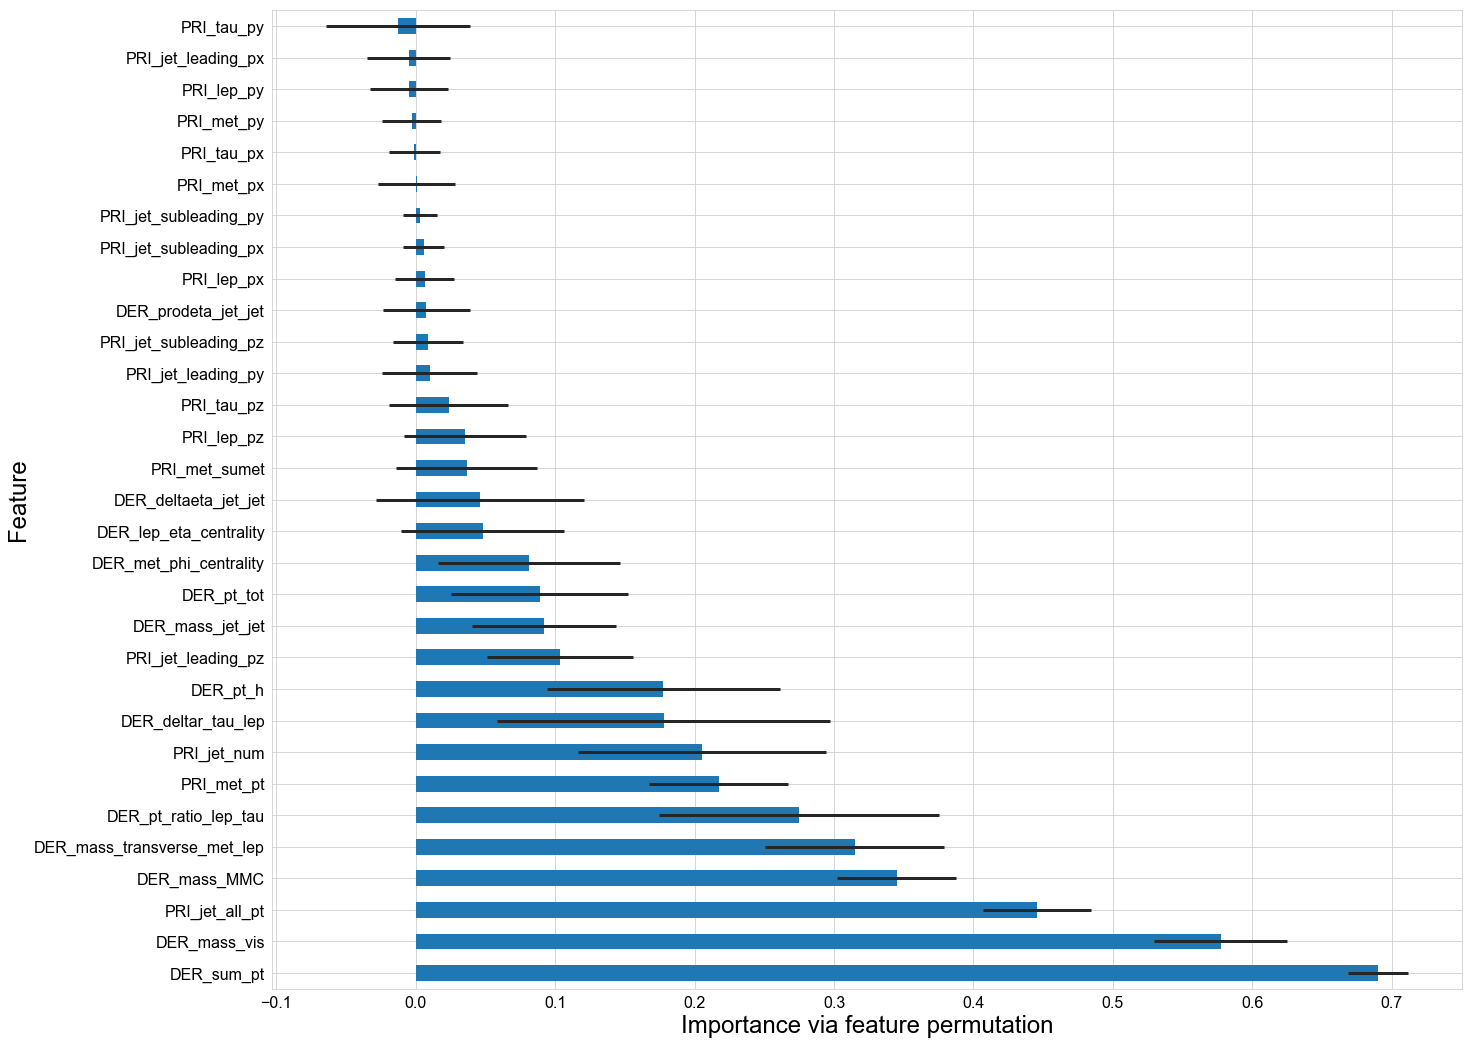

In [67]:
from lumin.nn.metrics.class_eval import AMS

_ = ensemble.get_feat_importance(train_fy, eval_metric=MultiAMS(n_total=250000, br=10,
                                    zero_preds=['pred_0', 'pred_1', 'pred_2'], one_preds=['pred_3'],
                                    targ_name='gen_target', wgt_name='gen_orig_weight'))

Ok, so the classifier really does make use of a range of features.

### Embeddings
We treated the number of jets (`PRI_jet_num`) as a categorical feature, but rather than one-hot encode it, we used an [entity embedding](https://arxiv.org/abs/1604.06737) matrix to learn a more optimal representation. We can take a look at this matrix and see what was learnt. If the binary classification example was ran first, then we would have loaded the initial embedding weights from a saved file, so we can also examine whether new weights were learnt, or if they remained similar.

In [68]:
_, m = ensemble[0]

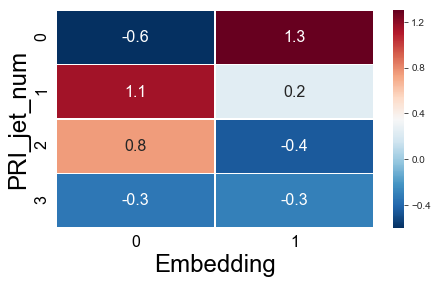

In [69]:
m.head.plot_embeds()

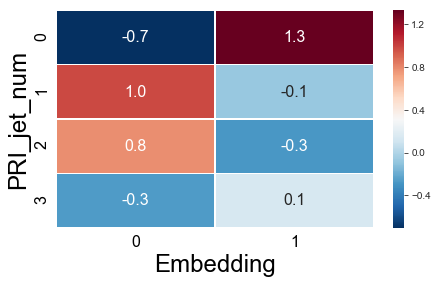

In [70]:
from lumin.plotting.interpretation import plot_embedding
import torch

plot_embedding(torch.load('weights/PRI_jet_num.h5', map_location='cpu'), 'PRI_jet_num')

The embedding weights seem to be relatively similar, and the jet multiplicity was ranked pretty high in importance, so we can assume that the weights offer a good encoding for the feature.

### Partial dependence
Another way to use our model rather than simply making decisions based the data, is to use to to better understand the data itself. In business, one could predict the influence that any handles that are available could have on some outcome. In high-energy physics, our available handles are quite limited; the collider is already built and difficult to modify. However it could be useful to have some information available to inform future decisions, or know where to concentrate algorithm development.

An example of how we can additionally use our model is plot the partial dependencies of the prediction on (pairs of) features. Basically this means taking a feature and working out how the prediction changes if everything else is kept the same and only the given feature is altered. `plot_1d_partial_dependence` and `plot_2d_partial_dependence` are wrapper functions for PDPbox, to handle the fact that our model expects pre-processed inputs, but we'd like to see the original data.

The PDPbox methods, however, only works for models with a single output, so we'll add an endcap to the model, to reduce the predictions to binary. Endcaps take a model as a parameter and then pass inputs to it, and then apply a function to the model outputs.

In [71]:
from lumin.nn.models.blocks.endcap import AbsEndcap
from torch import Tensor
import torch

class Multiclass2Binary(AbsEndcap):
    @staticmethod
    def func(x:Tensor) -> Tensor:
        x = torch.exp(x)
        zero = torch.max(x[:,0:3], dim=1)[0]
        tup = torch.cat((zero[:,None], x[:,3][:,None]), dim=1)
        preds = torch.max(tup, dim=1)
        preds[0][preds[1]==0] = 1-preds[0][preds[1]==0]
        return preds[0]

In [72]:
m = ensemble[0][1]
data = val_fy.get_fold(0)['inputs']

In [73]:
df = pd.DataFrame(m.predict(data), columns=[f'{x}' for x in range(4)])
to_binary_class(df, [f'{x}' for x in range(3)], ['3'])

In [74]:
endcap = Multiclass2Binary(m)
df['pred_2'] = endcap.predict(data)

In [75]:
df.head()

,0,1,2,3,pred,pred_2
0,0.002485,0.168754,0.755888,0.072873,0.244112,0.244112
1,0.008117,0.487749,0.221807,0.282326,0.512251,0.512251
2,0.027026,0.000248,0.000002,0.972724,0.972724,0.972724
3,0.110484,0.331699,0.006529,0.551289,0.551289,0.551289
4,0.098703,0.802379,0.073591,0.025327,0.197621,0.197621


Seems to be working

In [76]:
from lumin.plotting.interpretation import plot_1d_partial_dependence, plot_2d_partial_dependence

In [77]:
train_fy.add_input_pipe_from_file('data/input_pipe.pkl')
train_df = train_fy.get_df(inc_inputs=True, nan_to_num=True)

200000 datapoints loaded


/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:391: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


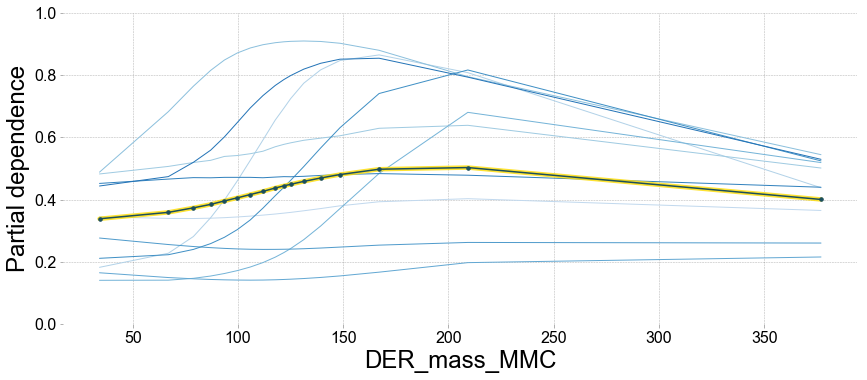

In [78]:
plot_1d_partial_dependence(endcap, df=train_df, feat='DER_mass_MMC', train_feats=train_feats, input_pipe=input_pipe,
                           sample_sz=2000, wgt_name='gen_weight', y_lim=[0,1],
                           pdp_isolate_kargs={'percentile_range':(1,99)})

Here we plotted the partial dependence of the Higgs mass on the class prediction. This involved taking each event and changing the `DER_mass_MMC` to different values, whilst keeping all the other features the same, and feeding the altered events through our model and tracking the prediction changes. Rather than plotting one line for each event, they are instead clustered into 10 'types' of event.

Nearly all lines increase towards a signal prediction around the Higgs mass (125), but some lines rise earlier, or later. The yellow line indicates the median event.

We can try other features, too:

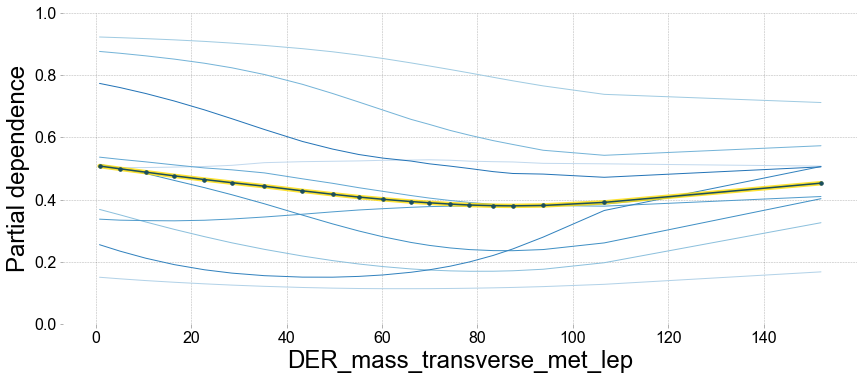

In [79]:
plot_1d_partial_dependence(endcap, df=train_df, feat='DER_mass_transverse_met_lep', train_feats=train_feats,
                           input_pipe=input_pipe, sample_sz=2000, wgt_name='gen_weight', y_lim=[0,1],
                           pdp_isolate_kargs={'percentile_range':(1,99)})

Or even get pair-wise partial dependencies

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'N'
  s)


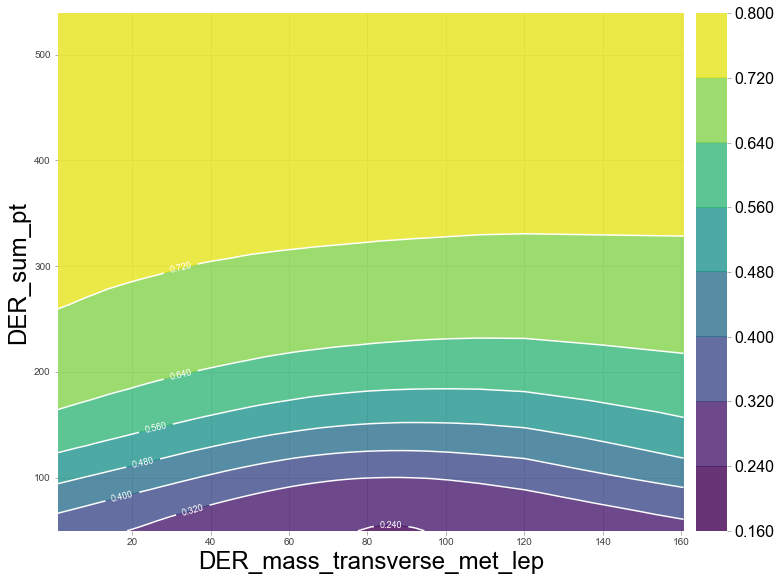

In [80]:
plot_2d_partial_dependence(endcap, df=train_df, feats=['DER_mass_transverse_met_lep','DER_sum_pt'],
                           train_feats=train_feats, input_pipe=input_pipe, n_points=(40,40), sample_sz=8000,
                           wgt_name='gen_weight', pdp_interact_kargs={'percentile_ranges':[(1,99),(1,99)]})